In [1]:
# Ativo Total - Conta 39999993

import pandas as pd
import numpy as np
import sqlite3

conn = sqlite3.connect('dados/banking.db')

query = """
WITH RankedData AS (
    SELECT
        *,
        ROW_NUMBER() OVER(PARTITION BY data ORDER BY "SALDO" DESC) AS rn
    FROM
        balancetes
    WHERE
        "CONTA" = '39999993'
)
SELECT
    *
FROM
    RankedData
WHERE
    rn <= 5;
"""

model = pd.read_sql_query(query, conn)

conn.close()

model = model[['data', 'cnpj', 'NOME_INSTITUICAO', 'SALDO']]
model['cnpj'] = (model['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
model.dropna(subset=['cnpj'], inplace=True)
model['cnpj'] = model['cnpj'].astype(int)
model = model.rename(columns={'SALDO': 'ativo_total'})


In [2]:
# Patrimônio Líquido - Conta 60000002

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    balancetes
WHERE
    "CONTA" = '60000002'
"""

table = pd.read_sql_query(query, conn)

conn.close()

table = table[['data', 'cnpj', 'SALDO']]
table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'SALDO': 'patrimonio_liquido'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [3]:
# Despesa Operacional
'''
81000005	(-) DESPESAS OPERACIONAIS
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('81000005')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'despesa_operacional'})
table['despesa_operacional'] = -table['despesa_operacional']

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [4]:
# OPEX - Despesa operacional / Ativo

model['opex'] = 100* model['despesa_operacional'] / model['ativo_total']

In [5]:
# Operações de Crédito
'''
16000001 - Operações de Crédito
'''
conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    data,
    cnpj,
    SUM("SALDO") AS saldo_total_agregado
FROM
    balancetes
WHERE
    "CONTA" IN ('16000001')
GROUP BY
    data,
    cnpj
ORDER BY
    data,
    cnpj;
"""

table = pd.read_sql_query(query, conn)
conn.close()

table['cnpj'] = (table['cnpj'].astype(str).str.strip().replace('', np.nan).replace('nan', np.nan))
table.dropna(subset=['cnpj'], inplace=True)
table['cnpj'] = table['cnpj'].astype(int)
table = table.rename(columns={'saldo_total_agregado': 'operacoes_de_credito'})

model = pd.merge(
    model,
    table,
    on=['data', 'cnpj'],
    how='left'
)


In [ ]:
model_12 = model[model['data'].str.startswith('202') | model['data'].str.startswith('2019')].copy()

In [85]:
#model_12 = model[model['data'].str.endswith('12') | model['data'].str.endswith('6')].copy()

# Tratando outliers usando o método do IQR (Interquartile Range)
colunas_para_analisar = ['despesa_operacional', 'opex']

# True significa que a linha *será removida* (outlier).
# Começamos com False, assumindo que nenhuma linha será removida inicialmente.
mascara_outliers_acumulada = pd.Series(False, index=model_12.index)

print(f"Tamanho do DataFrame antes da remoção: {len(model_12)}")

for col in colunas_para_analisar:
    Q1 = model_12[col].quantile(0.10)
    Q3 = model_12[col].quantile(0.90)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    mascara_outliers_coluna = (model_12[col] < limite_inferior) | (model_12[col] > limite_superior)

    mascara_outliers_acumulada = mascara_outliers_acumulada | mascara_outliers_coluna

    num_outliers_col = mascara_outliers_coluna.sum()
    print(f"Coluna '{col}': {num_outliers_col} outliers identificados (Limites: [{limite_inferior:.2f}, {limite_superior:.2f}])")


# Criamos uma máscara de linhas *a serem mantidas* (True = não é outlier)
mascara_a_manter = ~mascara_outliers_acumulada # O til (~) inverte a máscara
model_12 = model_12[mascara_a_manter]

print(f"\nTotal de linhas removidas: {mascara_outliers_acumulada.sum()}")
print(f"Tamanho do DataFrame após a remoção: {len(model_12)}")

Tamanho do DataFrame antes da remoção: 900
Coluna 'despesa_operacional': 0 outliers identificados (Limites: [-187148233440.72, 312886818800.99])
Coluna 'opex': 7 outliers identificados (Limites: [-2.56, 4.28])

Total de linhas removidas: 7
Tamanho do DataFrame após a remoção: 893


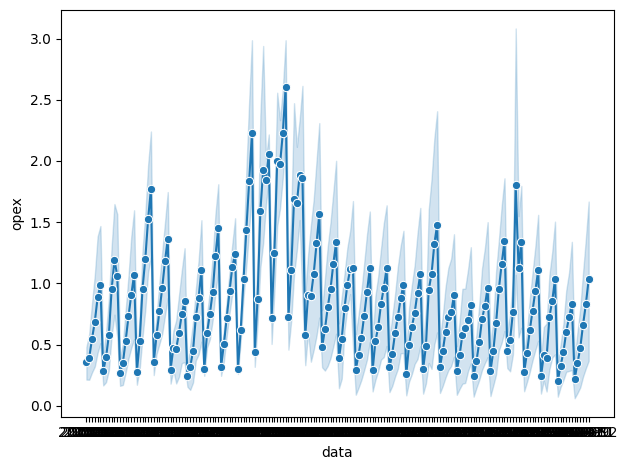

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

bb = model_12[model_12['cnpj'] == 0]
#bb= bb.loc[bb['data'].astype(str).str.endswith('12'), 'cnpj']
sns.lineplot(data= model_12, x='data', y='opex', marker='o', linestyle='-')

#plt.grid(True, linestyle='--', alpha=0.7) # Adiciona grade
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()


/tmp/ipykernel_1906663/308351261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_12['date'] = pd.to_datetime(model_12['data'], format='mixed')


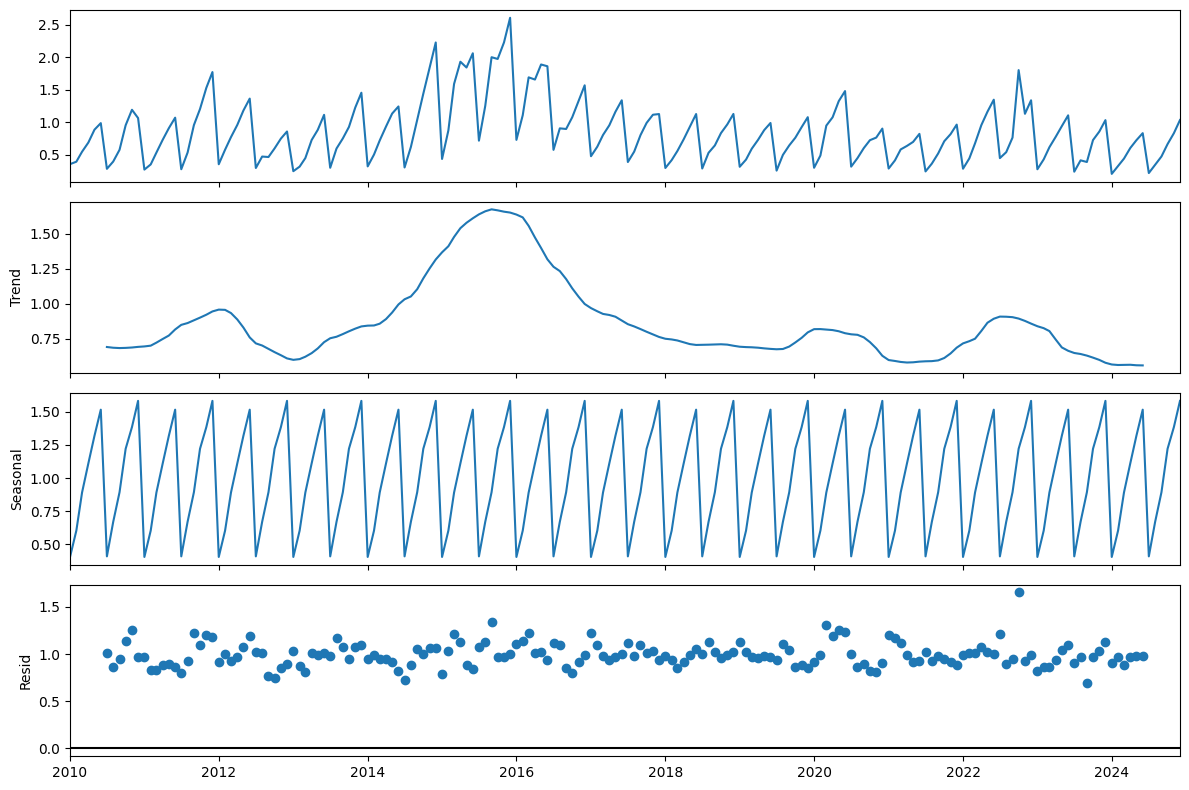

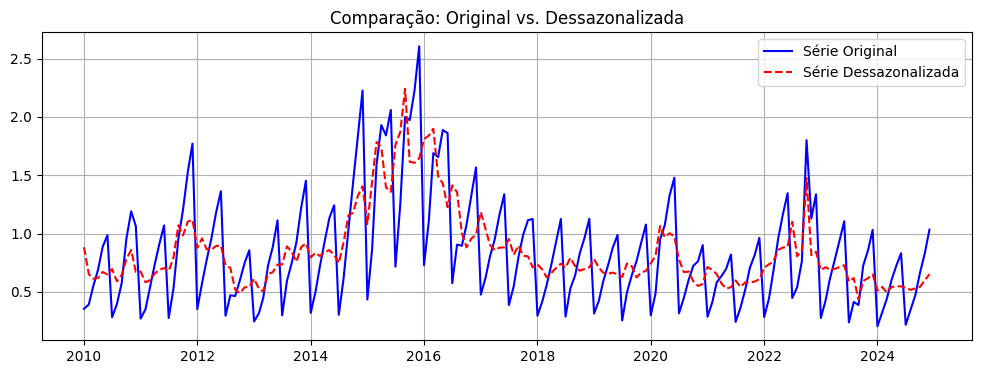

In [87]:
# Decomposição Sazonal usando statsmodels

model_12['date'] = pd.to_datetime(model_12['data'], format='mixed')
df_agregado = model_12.groupby('date')['opex'].mean().reset_index()
serie = pd.Series(df_agregado['opex'].values, index=df_agregado['date'])

serie = serie.interpolate(method='linear').asfreq('MS')

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Escolher o Modelo:
# Se as flutuações sazonais forem constantes (amplitude similar), use 'additive'.
# Se as flutuações sazonais aumentarem com o nível da série, use 'multiplicative'.

modelo = 'multiplicative' # Exemplo: Usando o modelo Multiplicativo

# 2. Realizar a Decomposição:
resultado = seasonal_decompose(serie, model=modelo)

if modelo == 'additive':
    serie_dessazonalizada = resultado.observed - resultado.seasonal
else: # Multiplicativo
    serie_dessazonalizada = resultado.observed / resultado.seasonal

serie_dessazonalizada.name = 'Série Dessazonalizada'

fig = resultado.plot()
fig.set_size_inches(12, 8)
fig.tight_layout()
plt.show()

# Plot da Série Original vs. Dessazonalizada
plt.figure(figsize=(12, 4))
plt.plot(resultado.observed, label='Série Original', color='blue')
plt.plot(serie_dessazonalizada, label='Série Dessazonalizada', color='red', linestyle='--')
plt.title('Comparação: Original vs. Dessazonalizada')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
import statsmodels.api as sm

time_index = np.arange(len(serie_dessazonalizada))

# Adiciona uma constante (necessária para o intercepto no OLS)
X = sm.add_constant(time_index)
Y = serie_dessazonalizada.values

# 2. Ajustar o Modelo OLS (Mínimos Quadrados Ordinários)
modelo_tendencia = sm.OLS(Y, X, missing='drop').fit()

# 3. Exibir Resultados
print(modelo_tendencia.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     9.732
Date:                Tue, 18 Nov 2025   Prob (F-statistic):            0.00211
Time:                        18:13:51   Log-Likelihood:                -50.424
No. Observations:                 180   AIC:                             104.8
Df Residuals:                     178   BIC:                             111.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9743      0.048     20.382      0.0

In [89]:
import statsmodels.api as sm

model_12['Trend'] = range(1, len(model_12) + 1)
X = model_12['Trend'] # X agora é um número inteiro/float
#X = model_12['data']
y = model_12['opex']

stage1 = sm.OLS(y, sm.add_constant(X)).fit()
results_stage1 = stage1
print(results_stage1.summary())




                            OLS Regression Results                            
Dep. Variable:                   opex   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.702
Date:                Tue, 18 Nov 2025   Prob (F-statistic):            0.00563
Time:                        18:14:16   Log-Likelihood:                -889.38
No. Observations:                 893   AIC:                             1783.
Df Residuals:                     891   BIC:                             1792.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9395      0.044     21.386      0.0

/tmp/ipykernel_1906663/2628628881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_12['Trend'] = range(1, len(model_12) + 1)


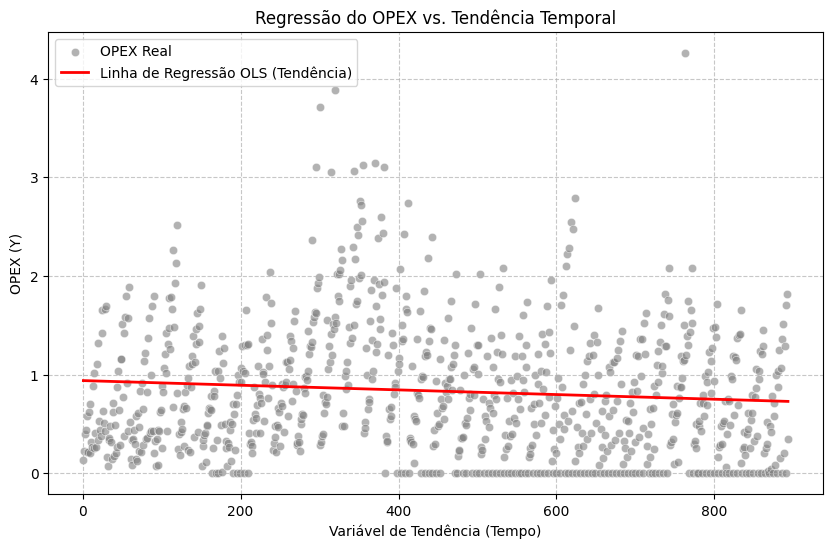

In [90]:

plt.figure(figsize=(10, 6))

# 1. Plotar os Pontos de Dados Reais
# Use a variável X (Trend) e a variável y (opex)
sns.scatterplot(
    x=X, 
    y=y, 
    label='OPEX Real', 
    color='gray', 
    alpha=0.6
)

# 2. Plotar a Linha de Regressão Estimada
# Usamos o método .predict() dos resultados para obter os valores ajustados (y_hat)
# Ordenamos os valores de X para garantir que a linha seja plotada corretamente
sns.lineplot(
    x=X, 
    y=results_stage1.predict(), # Resultados da previsão (y_hat)
    label='Linha de Regressão OLS (Tendência)', 
    color='red', 
    linewidth=2
)

# 3. Personalização do Gráfico
plt.title('Regressão do OPEX vs. Tendência Temporal')
plt.xlabel('Variável de Tendência (Tempo)')
plt.ylabel('OPEX (Y)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()